In [0]:
# helper to download the Data Set from Google Drive

import requests
import os

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

In [0]:
# Download the pre processed data set
file_id = '1snoB3mte3eyzYOEQTJAaRWz7M-7cJMjb'

destination = 'RAVDESS_train.zip'

if not os.path.exists(destination):
    download_file_from_google_drive(file_id, destination)

In [35]:
!ls -lh

total 350M
-rw-r--r-- 1 root root 197M Dec 17 19:20 bestmodel.hdf5
drwxr-xr-x 3 root root 4.0K Dec 17 18:47 RAVDESS
-rw-r--r-- 1 root root 154M Dec 17 18:47 RAVDESS_train.zip
drwxr-xr-x 1 root root 4.0K Dec 12 16:48 sample_data


In [36]:
!unzip RAVDESS_train.zip

Archive:  RAVDESS_train.zip
replace RAVDESS/train_valid/test/fearful/03-01-06-02-01-01-05-100.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [37]:
!ls RAVDESS/train_valid/test -lh

total 32K
drwxr-xr-x 2 root root 4.0K Dec 15 12:17 angry
drwxr-xr-x 2 root root 4.0K Dec 15 12:17 calm
drwxr-xr-x 2 root root 4.0K Dec 15 12:17 disgust
drwxr-xr-x 2 root root 4.0K Dec 15 12:17 fearful
drwxr-xr-x 2 root root 4.0K Dec 15 12:17 happy
drwxr-xr-x 2 root root 4.0K Dec 15 12:17 neutral
drwxr-xr-x 2 root root 4.0K Dec 15 12:17 sad
drwxr-xr-x 2 root root 4.0K Dec 15 12:17 surprised


In [0]:
import numpy as np
import pandas as pd
import librosa
from scipy.signal import spectrogram
import math
import matplotlib.pyplot as plt
import seaborn as sn
import random
import re
import gc
from IPython.display import Image, display
from sklearn.model_selection import train_test_split
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [0]:
# create directory path helper variables
base_dir = 'RAVDESS/train_valid/'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

In [0]:
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet50 import ResNet50,preprocess_input,decode_predictions
from keras.preprocessing import image
from keras.layers import Conv2D, GlobalAveragePooling2D, Flatten, Dense, Dropout, InputLayer
from keras import backend as K
from keras.layers import Flatten
import numpy as np
from keras.models import Sequential
from keras import optimizers
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix

In [0]:
resnet_img_height=128
resnet_img_width=200

In [42]:
# using a pretrained resnet model, dowloading without the top layers
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(resnet_img_height,resnet_img_width,3))
for layer in base_model.layers:
    layer.trainable = True

# adding the top layers for classification  
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(8, activation='softmax')(x)
model = Model(base_model.input, predictions)
model.summary()

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 128, 200, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 206, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 64, 100, 64)  9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 64, 100, 64)  256         conv1[0][0]                      
____________________________________________________________________________________________

In [0]:
# compile the model, with rmsprop optimizer
model.compile(optimizer='rmsprop', metrics=['accuracy'], loss='categorical_crossentropy')

# add callbacks for early stopping
checkpointer = ModelCheckpoint(filepath='bestmodel.hdf5', verbose=1, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss', patience=15, verbose=1)

In [44]:
print("Number of original train images: " + str(sum([len(files) for r, d, files in os.walk(train_dir)])))
print("Number of original validation images: " + str(sum([len(files) for r, d, files in os.walk(validation_dir)])))
print("Number of original test images: " + str(sum([len(files) for r, d, files in os.walk(test_dir)])))

Number of original train images: 4931
Number of original validation images: 615
Number of original test images: 621


In [45]:
# Load the images with ImageDataGenerator. The original images are not augmented as we have a fixed time series images. The Image is rescaled to 0..1 range.
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=0, width_shift_range=0, height_shift_range=0, zoom_range=0, horizontal_flip=False, vertical_flip=False)
validation_datagen = ImageDataGenerator(rescale=1./255, rotation_range=0, width_shift_range=0, height_shift_range=0, zoom_range=0, horizontal_flip=False, vertical_flip=False)
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(resnet_img_height, resnet_img_width), batch_size=32, class_mode='categorical', seed=42)
validation_generator = validation_datagen.flow_from_directory(validation_dir, target_size=(resnet_img_height, resnet_img_width), batch_size=32, class_mode='categorical', seed=42)

Found 4931 images belonging to 8 classes.
Found 615 images belonging to 8 classes.


In [46]:
# The model used the train generator to load and randomize the data. 
history = model.fit(train_generator,steps_per_epoch=5,validation_data=validation_generator,validation_steps=10,epochs=150, callbacks=[checkpointer, earlystopper])

Epoch 1/150
5/5 [==============================] - 129s 26s/step - loss: 4.5037 - acc: 0.1500 - val_loss: 2.2267 - val_acc: 0.1625

Epoch 00001: val_loss improved from inf to 2.22668, saving model to bestmodel.hdf5
Epoch 2/150
5/5 [==============================] - 111s 22s/step - loss: 3.2995 - acc: 0.2000 - val_loss: 2.1992 - val_acc: 0.1593

Epoch 00002: val_loss improved from 2.22668 to 2.19919, saving model to bestmodel.hdf5
Epoch 3/150
5/5 [==============================] - 114s 23s/step - loss: 3.1213 - acc: 0.1938 - val_loss: 2.1494 - val_acc: 0.2375

Epoch 00003: val_loss improved from 2.19919 to 2.14942, saving model to bestmodel.hdf5
Epoch 4/150
5/5 [==============================] - 110s 22s/step - loss: 2.7589 - acc: 0.2312 - val_loss: 2.4761 - val_acc: 0.2508

Epoch 00004: val_loss did not improve from 2.14942
Epoch 5/150
5/5 [==============================] - 114s 23s/step - loss: 3.0734 - acc: 0.2375 - val_loss: 3.0681 - val_acc: 0.2062

Epoch 00005: val_loss did not im

In [47]:
# loading back the best model
saved_model = load_model('bestmodel.hdf5')

train_evaluated = saved_model.evaluate(train_generator)
validation_evaluated = saved_model.evaluate(validation_generator)
print('Training Accuracy: %.3f%%, Training Loss: %.3f' % (train_evaluated[1]*100, train_evaluated[0]))
print('Validation Accuracy: %.3f%%, Validation Loss: %.3f' % (validation_evaluated[1]*100, validation_evaluated[0]))

20/20 [==============================] - 90s 4s/step
Training Accuracy: 31.596%, Training Loss: 2.076
Validation Accuracy: 29.593%, Validation Loss: 2.136


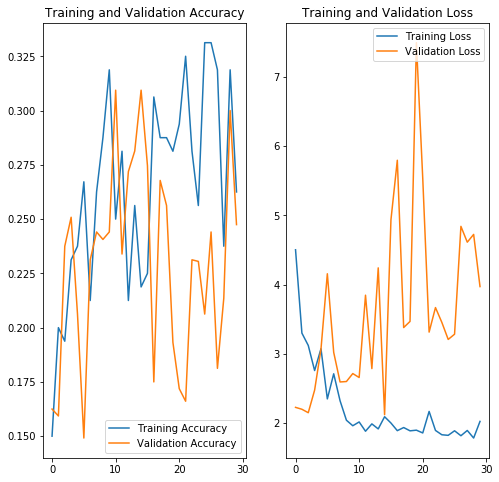

In [48]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(loss))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [49]:
test_datagen = ImageDataGenerator(rescale=1./255, rotation_range=0, width_shift_range=0, height_shift_range=0, zoom_range=0, horizontal_flip=False, vertical_flip=False)
test_generator = test_datagen.flow_from_directory(test_dir, shuffle=False, target_size=(resnet_img_height, resnet_img_width), batch_size=32, class_mode='categorical', seed=42)

#Confusion Matrix
Y_pred = model.predict_generator(test_generator)
print(Y_pred.shape)
y_pred = np.argmax(Y_pred, axis=1)
emotions_confusion_matrix = confusion_matrix(test_generator.classes, y_pred)
print(emotions_confusion_matrix)


Found 621 images belonging to 8 classes.
(621, 8)
[[60  0  6  9  0  0  6  5]
 [13  1 19 10  0  0 24 23]
 [31  0 22  6  0  0 19 18]
 [24  0  2 23  0  0 11 19]
 [32  0  1 20  0  0 12 12]
 [12  0  5  4  0  0  2 13]
 [22  0 10 17  0  0 20 18]
 [13  0 10 14  0  0  7 26]]


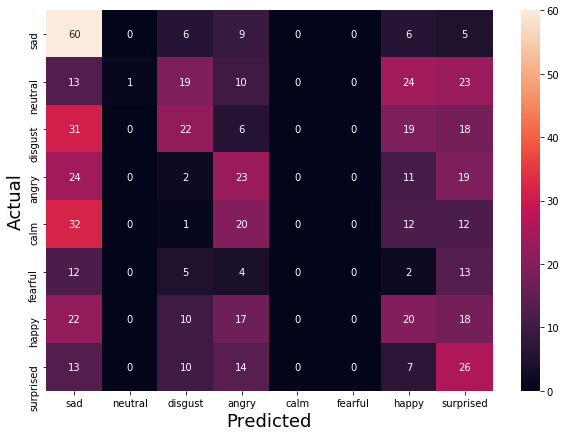

In [51]:
emotions = os.listdir(test_dir)
emotion_confusion_df = pd.DataFrame(emotions_confusion_matrix, index = emotions,
                  columns = emotions)
plt.figure(figsize = (10,7))
sn.heatmap(emotion_confusion_df, annot=True)
plt.xlabel('Predicted', fontsize=18)
plt.ylabel('Actual', fontsize=18)
plt.show()